<a href="https://colab.research.google.com/github/vishva2410/Deep-Learning-Projects-Part-A-/blob/main/Pneumonia_detection_using_CNN_and_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gradio

In [ ]:
import numpy as np
from zipfile import ZipFile
import gradio as gr
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import tensorflow as tf
import os
import cv2
import random
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models

In [ ]:
path_train = "/content/chest_xray/train"
print(os.listdir(path_train))
classes = os.listdir(path_train)

['PNEUMONIA', 'NORMAL', '.DS_Store']


In [ ]:
path_test = "/content/chest_xray/test"
print(os.listdir(path_test))

['PNEUMONIA', 'NORMAL', '.DS_Store']


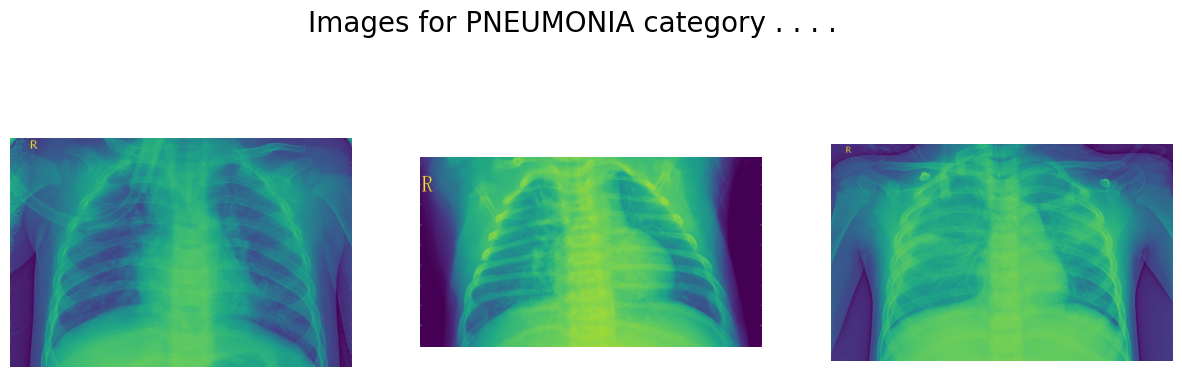

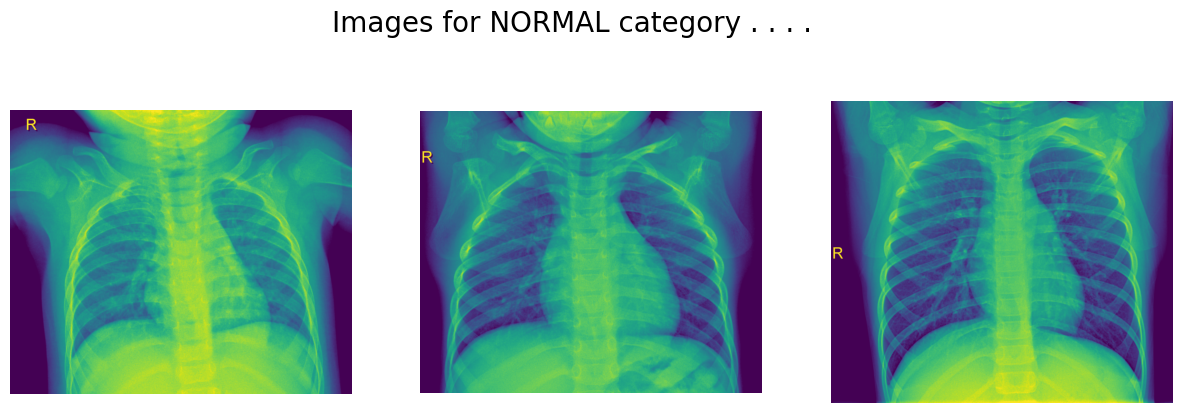

In [ ]:
for cat in classes:
  if cat != ".DS_Store" and os.path.isdir(os.path.join(path_train, cat)):
    image_dir = f'{path_train}/{cat}'
    images = os.listdir(image_dir)
    images = [img for img in images if os.path.isfile(os.path.join(image_dir, img))]
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        if images:
            k = np.random.randint(0, len(images))
            img = np.array(Image.open(f'{path_train}/{cat}/{images[k]}'))
            ax[i].imshow(img)
            ax[i].axis('off')
        else:
            print(f"No images found in directory: {image_dir}")
    plt.show()

In [ ]:
train_folder = ["/content/chest_xray/train/NORMAL","/content/chest_xray/train/PNEUMONIA"]
test_folder = ["/content/chest_xray/test/NORMAL","/content/chest_xray/test/PNEUMONIA"]

IMG_SIZE = 128
SPLIT = 0.2

classes = ["NORMAL","PNEUMONIA"]

X_train,Y_train,X_test,Y_test = [],[],[],[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [ ]:
for i,train_path in  enumerate(train_folder):
  images = glob(f"{train_path}/*.*")
  print(f"Found {len(images)} images in {train_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = clahe.apply(img)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    X_train.append(img)
    Y_train.append(i)

Found 1341 images in /content/chest_xray/train/NORMAL
Found 3875 images in /content/chest_xray/train/PNEUMONIA


In [ ]:
for i,test_path in  enumerate(test_folder):
  images = glob(f"{test_path}/*.*")
  print(f"Found {len(images)} images in {test_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = clahe.apply(img)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    X_test.append(img)
    Y_test.append(i)

Found 234 images in /content/chest_xray/test/NORMAL
Found 390 images in /content/chest_xray/test/PNEUMONIA


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=2)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=2)

In [ ]:
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

In [ ]:
X_train_rgb = np.stack([X_train]*3, axis=-1)
X_test_rgb = np.stack([X_test]*3, axis=-1)

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [ ]:
X_train_rgb = X_train_rgb.reshape(-1, 128, 128, 3)
X_test_rgb = np.stack((X_test,) * 3, axis=-1)  # Shape: (624, 128, 128, 3)
X_train_rgb = X_train_rgb[:5216]

In [ ]:
X_train_rgb = np.array(X_train_rgb)
X_test_rgb = np.array(X_test_rgb)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=10, batch_size=32,
          validation_data=(X_test, Y_test),
          callbacks=[early_stop])


Epoch 1/10


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [ ]:
print(X_train_rgb.shape)  # (5216, 128, 128, 3)
print(X_test_rgb.shape)   # (624, 128, 128, 3)


(15648, 128, 128, 3)
(624, 128, 128, 3)


In [ ]:
print(X_train_rgb.shape)  # Should be (N, 128, 128, 3)
print(Y_train.shape)      # Should be (N,) or (N, num_classes) depending on task
print(X_test_rgb.shape)   # Should be (N, 128, 128, 3)
print(Y_test.shape)       # Should be (N,) or (N, num_classes) depending on task

(15648, 128, 128, 3)
(5216,)
(624, 128, 128, 3)
(624,)
